# Experiment with different distance metrics & clustering algorithms

In [2]:
import time
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics.cluster import normalized_mutual_info_score

import data_loader
import pp
import clustering

import scanpy as sc


%load_ext autoreload
%autoreload 2

## Data Loading

In [4]:
# Local path 
DATA_PATH = '/projects/zhanglab/users/johnson/data/GSE75748_processed.h5ad'

# Loading raw data
adata = data_loader.load_annData(DATA_PATH)    
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 1018 × 19097

## Data Preprocessing

In [5]:
# Preprocess data # pp.preprocess(adata)
pp.filter_cell(adata, min_genes = 200)
pp.filter_gene(adata, min_cells = 3)
pp.filter_mt_genes(adata)
pp.normalize_size(adata, target_sum = 1e4)
pp.normalize_log(adata)
pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
adata

/home/yenhsian/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


AnnData object with n_obs × n_vars = 1018 × 17559
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## Clustering

### True labels

parse true labels from cell's name

In [6]:
# Classification based on the name of data
from collections import Counter

def encode(celltypes):
    labels_dict = {}
    labels = []
    cur = 0

    for c in celltypes:
        if c not in labels_dict:
            labels_dict[c] = cur
            cur += 1 # increase smallest index
        labels.append(labels_dict[c])
    return labels, labels_dict


celltypes = pd.Series(adata.obs_names).apply(lambda x : x.split('_')[0].upper())
labels, labels_dict = encode(celltypes)

adata.obs['true_label'] = labels
labels_dict

{'H1': 0, 'H9': 1, 'DEC': 2, 'EC': 3, 'HFF': 4, 'NPC': 5, 'TB': 6}

### Leidon

In [12]:
# PCA
clustering.pca(adata, svd_solver='arpack')
# KNN
clustering.neighbors(adata, n_neighbors = 10, use_pca = True)
# Leiden-clustering based on PCA
clustering.cluster_leiden(adata)
# UMAP embedding based on KNN
sc.tl.umap(adata)

leiden completed, time=0.2s


### K-medoids

#### Clustering with different metrics

In [7]:
from banditpam import KMedoids
from sklearn.metrics.cluster import normalized_mutual_info_score 

df_score = pd.DataFrame()
df_score.index.name = 'k'

for metric in ['L1', 'L2', 'inf', 'cos', 'manhattan']:

    score_list = []
    for k in range(1, 9):
        clustering.cluster_banditpam(adata, n_medoids = k, metric = metric)
        nmi = normalized_mutual_info_score(adata.obs['true_label'], adata.obs['kmed_'+metric])
        score_list.append(nmi)
    df_score[metric] = score_list

df_score.index = range(1,9)
df_score

kmed_L1 (K = 1) completed, time=5.5s
kmed_L1 (K = 2) completed, time=8.1s
kmed_L1 (K = 3) completed, time=11.0s
kmed_L1 (K = 4) completed, time=10.5s
kmed_L1 (K = 5) completed, time=11.9s
kmed_L1 (K = 6) completed, time=13.1s
kmed_L1 (K = 7) completed, time=12.7s
kmed_L1 (K = 8) completed, time=13.6s
kmed_L2 (K = 1) completed, time=5.2s
kmed_L2 (K = 2) completed, time=7.1s
kmed_L2 (K = 3) completed, time=7.2s
kmed_L2 (K = 4) completed, time=11.7s
kmed_L2 (K = 5) completed, time=11.9s
kmed_L2 (K = 6) completed, time=12.0s
kmed_L2 (K = 7) completed, time=12.3s
kmed_L2 (K = 8) completed, time=13.2s
kmed_inf (K = 1) completed, time=7.2s
kmed_inf (K = 2) completed, time=11.5s
kmed_inf (K = 3) completed, time=12.1s
kmed_inf (K = 4) completed, time=11.5s
kmed_inf (K = 5) completed, time=12.1s
kmed_inf (K = 6) completed, time=14.5s
kmed_inf (K = 7) completed, time=13.9s
kmed_inf (K = 8) completed, time=14.1s
kmed_cos (K = 1) completed, time=64.0s
kmed_cos (K = 2) completed, time=84.6s
kmed_cos

,L1,L2,inf,cos,manhattan
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.393449,0.362432,0.277228,0.351122,0.393449
3,0.498312,0.612939,0.518972,0.604909,0.498312
4,0.651613,0.714816,0.690042,0.699292,0.651613
5,0.756759,0.787217,0.771131,0.788164,0.756759
6,0.829427,0.746648,0.835788,0.874418,0.829427
7,0.787117,0.811750,0.837603,0.840656,0.787117
8,0.801541,0.792346,0.781673,0.821420,0.801541


#### Find best K

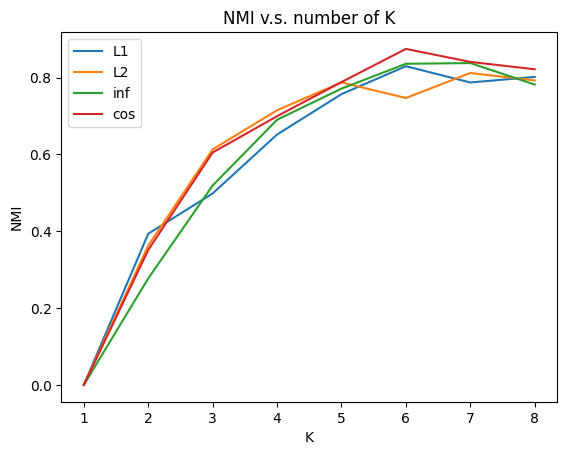

In [8]:
import matplotlib.pyplot as plt
colormap = plt.get_cmap('tab10')

for i, metric in enumerate(['L1', 'L2', 'inf', 'cos']):
    plt.plot(df_score.index, df_score[metric], label=metric, color=colormap(i))

plt.title('NMI v.s. number of K')
plt.xlabel('K')
plt.ylabel('NMI')
plt.legend()
plt.show()

In [9]:
clustering.cluster_banditpam(adata, n_medoids = 5, metric = 'L1')
clustering.cluster_banditpam(adata, n_medoids = 7, metric = 'L2')
clustering.cluster_banditpam(adata, n_medoids = 7, metric = 'inf')
clustering.cluster_banditpam(adata, n_medoids = 6, metric = 'cos')
clustering.cluster_banditpam(adata, n_medoids = 6, metric = 'manhattan')

kmed_L1 (K = 5) completed, time=12.5s
kmed_L2 (K = 7) completed, time=12.4s
kmed_inf (K = 7) completed, time=13.9s
kmed_cos (K = 6) completed, time=134.5s
kmed_manhattan (K = 6) completed, time=11.2s


In [10]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,true_label,kmed_L1,kmed_L2,kmed_inf,kmed_cos,kmed_manhattan
H1_Exp1.001,10206,10205,1496939.36,0.0,0.0,0,0,0,5,5,0,5
H1_Exp1.002,10279,10278,2171824.46,0.0,0.0,0,0,0,5,5,0,5
H1_Exp1.003,10373,10373,1729813.42,0.0,0.0,8,0,0,5,5,0,5
H1_Exp1.004,10145,10144,1394034.71,0.0,0.0,0,0,0,0,5,0,5
H1_Exp1.006,9989,9989,1422278.17,0.0,0.0,0,0,0,0,5,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
TB_Batch2.140,9348,9348,3978420.45,0.0,0.0,7,6,4,3,4,4,4
TB_Batch2.141,9705,9701,3982474.22,0.0,0.0,7,6,4,3,0,4,4
TB_Batch2.142,9753,9752,6005458.01,0.0,0.0,7,6,4,3,4,4,4
TB_Batch2.143,9748,9747,5586397.22,0.0,0.0,7,6,4,3,4,4,4


#### Visualize clustering result 

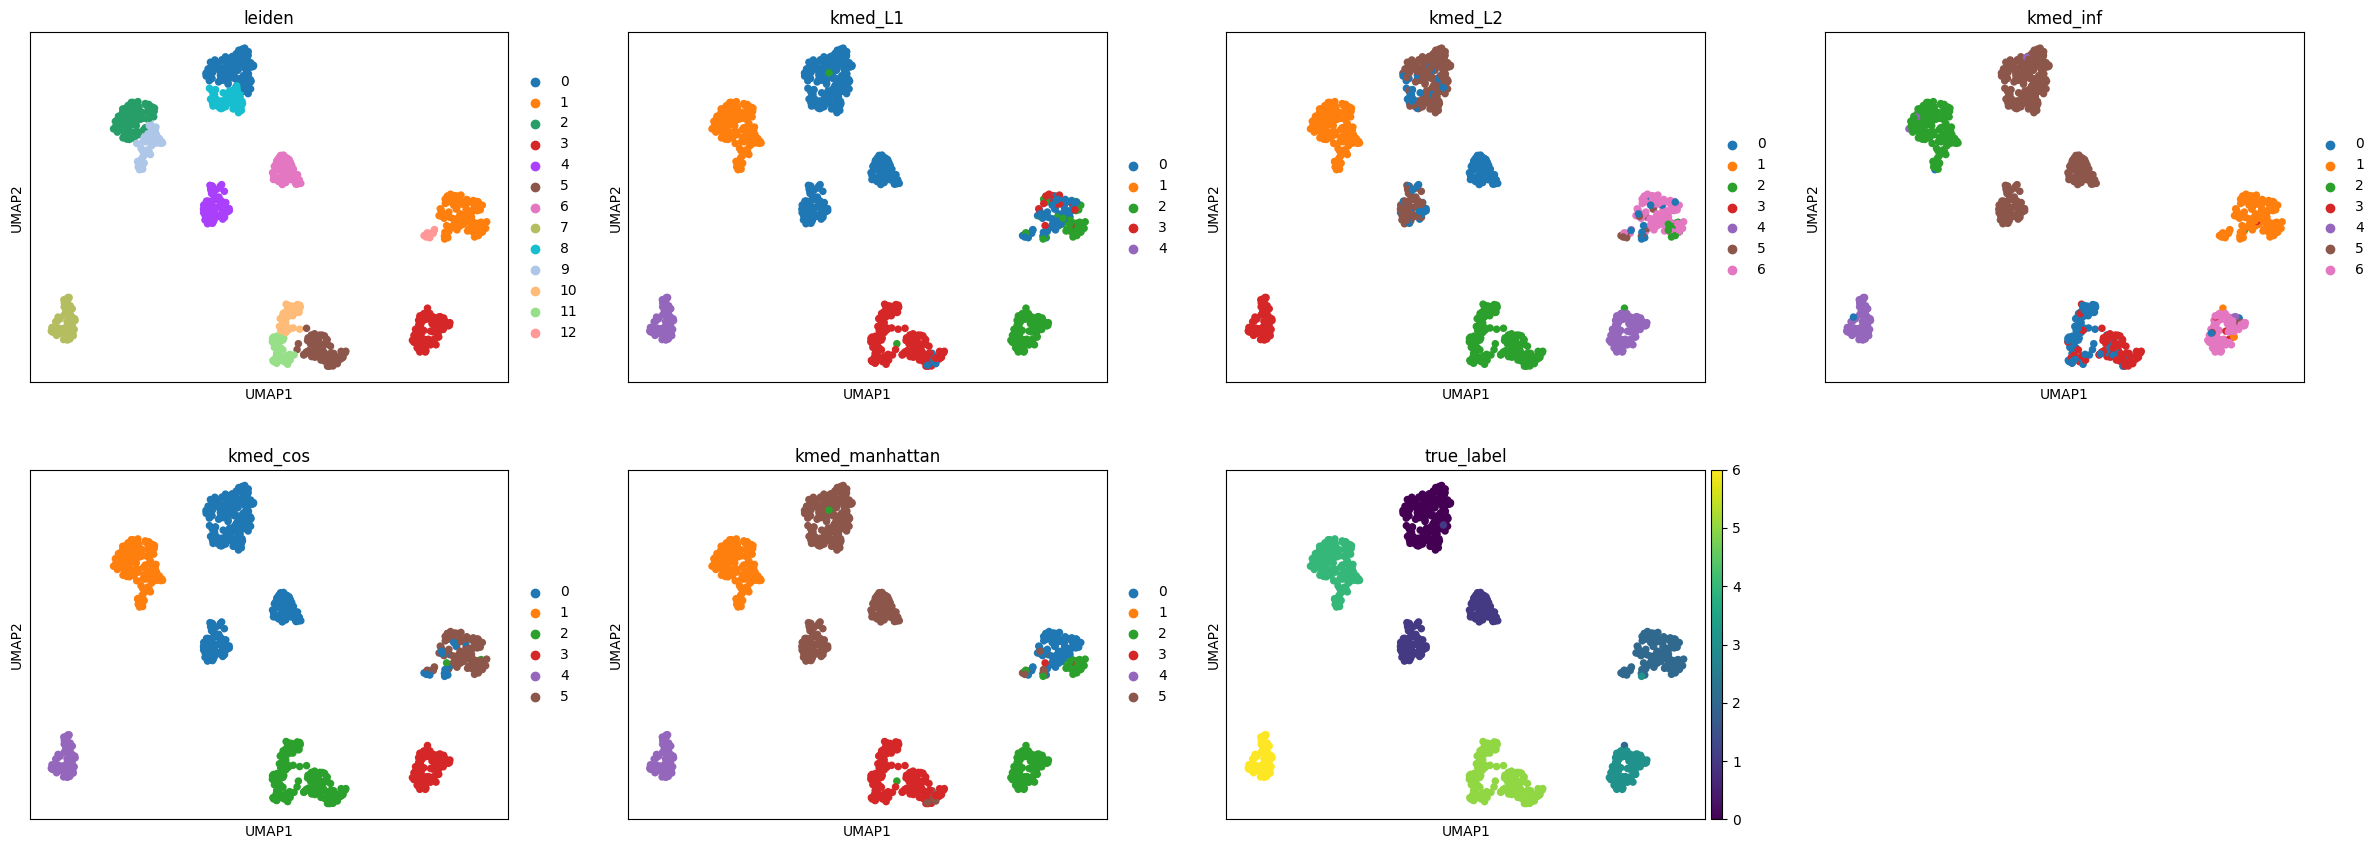

In [11]:
# True labels are stored in adata.obs
import warnings
warnings.filterwarnings('ignore')
sc.pl.umap(adata, color=['leiden', 'kmed_L1' , 'kmed_L2' , 'kmed_inf', 'kmed_cos', 'kmed_manhattan' ,'true_label'])

#### Benchmarking clustering

use NMI

In [12]:
from sklearn.metrics import normalized_mutual_info_score

print('leiden: ', normalized_mutual_info_score(adata.obs['true_label'], adata.obs['leiden']))
for metric in ['L1', 'L2', 'inf', 'cos', 'manhattan']:
    print(f"kmed {metric}: {normalized_mutual_info_score(adata.obs['true_label'], adata.obs['kmed_'+metric])}")

leiden:  0.864679847570812
kmed L1: 0.7567585935808072
kmed L2: 0.8117495093963216
kmed inf: 0.8376028678949661
kmed cos: 0.8744180651943413
kmed manhattan: 0.8294267332044231


In [15]:
for i in range(10):
    clustering.cluster_banditpam(adata, n_medoids = 7, metric = 'L1')
    print(i)
    print(normalized_mutual_info_score(adata.obs['true_label'], adata.obs['kmed_L1']))

kmed_L1 (K = 7) completed, time=13.1s
0
0.7871168201309223
kmed_L1 (K = 7) completed, time=13.1s
1
0.7871168201309224
kmed_L1 (K = 7) completed, time=13.2s
2
0.7871168201309223
kmed_L1 (K = 7) completed, time=12.5s
3
0.7871168201309223


KeyboardInterrupt: 

In [14]:
for i in range(5):
    score_dic = {}
    for metric in ['L1', 'L2', 'inf', 'cos', 'manhattan']:
        score_list = []
        for k in range(5, 9):
            clustering.cluster_banditpam(adata, n_medoids = k, metric = metric)
            nmi = normalized_mutual_info_score(adata.obs['true_label'], adata.obs['kmed_'+metric])
            score_list.append(nmi)
        max_value = max(score_list)
        score_dic[metric] = max_value
    print(i)
    print('leiden: ', normalized_mutual_info_score(adata.obs['true_label'], adata.obs['leiden']))
    for metric in ['L1', 'L2', 'inf', 'cos', 'manhattan']: 
        print(f"kmed {metric}: {score_dic[metric]}")

kmed_L1 (K = 5) completed, time=12.9s
kmed_L1 (K = 6) completed, time=13.2s
kmed_L1 (K = 7) completed, time=13.1s
kmed_L1 (K = 8) completed, time=13.3s
kmed_L2 (K = 5) completed, time=12.3s
kmed_L2 (K = 6) completed, time=12.2s
kmed_L2 (K = 7) completed, time=12.6s
kmed_L2 (K = 8) completed, time=13.7s
kmed_inf (K = 5) completed, time=12.1s
kmed_inf (K = 6) completed, time=13.6s
kmed_inf (K = 7) completed, time=13.3s
kmed_inf (K = 8) completed, time=13.5s
kmed_cos (K = 5) completed, time=117.2s
kmed_cos (K = 6) completed, time=133.1s
kmed_cos (K = 7) completed, time=132.6s
kmed_cos (K = 8) completed, time=138.6s
kmed_manhattan (K = 5) completed, time=11.0s
kmed_manhattan (K = 6) completed, time=11.4s
kmed_manhattan (K = 7) completed, time=11.3s
kmed_manhattan (K = 8) completed, time=11.4s
0
leiden:  0.864679847570812
kmed L1: 0.8294267332044231
kmed L2: 0.8117495093963216
kmed inf: 0.8376028678949661
kmed cos: 0.8744180651943413
kmed manhattan: 0.8294267332044231
kmed_L1 (K = 5) comple

KeyboardInterrupt: 